In [ ]:
#Colab users uncomment this code
#File for this notebook is "NN_dataset.npz"

In [ ]:
"""
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
"""

In [ ]:
"""
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
"""

In [ ]:
"""
downloaded = drive.CreateFile({'id':'1R9vW5dmox7i8OGOoDql_r9yUrvAJgvhD'}) # replace the id with id of file you want to access
downloaded.GetContentFile('NN_dataset.npz')
"""

# Neural Networks Assignment (70)
<hr style="height:5px;border-width:2;color:gray">

## Introduction

In this assignment we will be implementing a Neural Network from scratch to get a better understanding of how a Neural Network works and why does adding a hidden layer improve its performance.<br>
In this assignment, you will be working with an artificially generated dataset. It is a small 2 dimensional $(\therefore n_x = 2)$ dataset, involving a binary classification task. The two features of $X$ are the $x$ and $y$ co-ordinates on the 2D plane. $Y$ can have 2 values, $0$ and $1$ indicating the two classes.<br>
The Assignment will be divided into 3 major sections:
<ol>
    <li><b>S1</b>: Applying a Logistic Regression model using sci-kit learn and see how it performs on the dataset.  (This step is already taken care for you)</li>
    <li><b>S2</b>: Implementing a Neural Network with 1 hidden layer and compare its performance with the Logitic Regression.</li>
    <li><b>S3</b>: Hyperparameter tuning to find the best fit for the dataset.</li>
</ol>

## Evaluation

<ul>
    <li>S1 is non-evaluative.</li>
    <li>The marks alloted to each step in S2 will be mentioned in the corresponding step. Just like numpy and pandas <b>60%</b> of marks will be allotted to <b>correctness of final answer</b> and <b>40%</b> of marks will be allotted to <b>conciseness of code</b>. As long as your code gives the correct output and doesn't have unnecessary code, you should be able to get full.</li>
    <li>In S3 you will have to tune the parameters to better fit the dataset and try to get a high test accuracy. Then this model will be run on a hidden dataset during evaluation and the accuracy on the hidden dataset will be noted.</li>
</ul>

Finally the leaderboard will be ranked <b>primarily on total marks</b> and <b>secondarily on hidden set accuracy</b>.

<hr style="height:2px;border-width:2;color:gray">

## Preparation

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Loading dataset.npz
<b>Note</b>: You may have to change filepath if the file is not saved in current directory

In [2]:
data = np.load("NN_dataset.npz")
X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

### Viewing shape

In [4]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of X_train: (2, 452)
Shape of Y_train: (1, 452)
Shape of X_test: (2, 194)
Shape of Y_test: (1, 194)


### Visualizing the training data

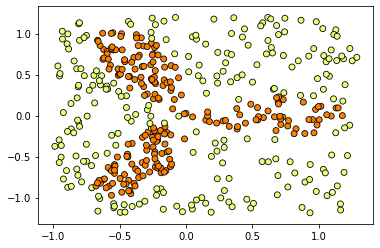

In [574]:
plt.scatter(X_train[0,:], X_train[1, :], c = Y_train.ravel(), cmap = plt.cm.Wistia, linewidths = 0.8, edgecolors = 'black')

As we can see, we will be needing a non-linear <b>Decision Boundary</b> to separate the 2 classes shown by 2 different colours.

### Function to plot the Decision Boundary

<b>Decision Boundary</b> for a classification task refers to the hypersurface that divides the two classes. In a 2D plane for a binary classification task, it is a curve that divides the plane into two halves where the points in one half belong to one class while the points in the other half belong to the other class. The goal of a classification task is to learn this curve.<br>
The function below plots the decision boundary for the fitted model. We'll use this to visualize the decision bundary learnt by our different models.

In [22]:
def plot_decision_boundary(predict_function, X, Y, trained_parameters = None):
    xmin, xmax = X[0,:].min() - 0.25, X[0,:].max() + 0.25
    ymin, ymax = X[1,:].min() - 0.25, X[1,:].max() + 0.25
    
    xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.01), np.arange(ymin, ymax, 0.01))
    if trained_parameters is None:
        z = predict_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = predict_function(np.c_[xx.ravel(), yy.ravel()].T, trained_parameters)
    z = z.reshape(xx.shape)
    
    plt.contourf(xx, yy, z, cmap=plt.cm.Wistia)
    plt.scatter(X[0,:], X[1,:], c = Y.ravel(), cmap = plt.cm.Wistia, linewidths = 0.8, edgecolors = 'black')

<hr style="height:2px;border-width:2;color:gray">

## S1: Logistic Regression

Let's use sci-kit learn to fit a Logistic Regression model on this dataset to see how it performs

In [576]:
# Importing LogisticRegression
from sklearn.linear_model import LogisticRegression

#Fitting the model
clf = LogisticRegression(solver = 'lbfgs').fit(X_train.T, Y_train.ravel().T) #Specifying solver to suppress warning

#Printing train and test set accuracy
print(f"Train set accruracy: {clf.score(X_train.T, Y_train.ravel().T)*100}"+"%")
print(f"Test set accuracy: {clf.score(X_test.T, Y_test.ravel().T)*100}"+"%")

Train set accruracy: 62.61061946902655%
Test set accuracy: 63.4020618556701%


Clearly, Logistic Regression performs badly on this data. Let's see why by visualizing the Decision Boundary.

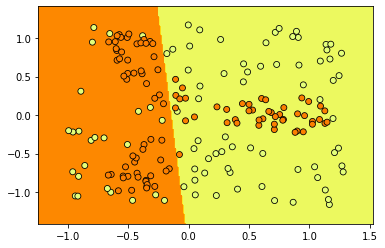

In [577]:
plot_decision_boundary(clf.predict, X_test, Y_test)

As we can see Logistic Regression is limited to fitting a linear decision boundary and hence cannot fit this data very well.

<hr style="height:2px;border-width:2;color:gray">

## S2: Implementing an Artificial Neural Network

### Architecture

For this task, our Neural Network will have 1 Input Layer (with 2 units), 1 Ouput Layer (with 1 unit) and <b>1 Hidden Layer (with $n_H$ units)</b>. The Hidden Layer will have the <b>tanh</b> activation function while the Output Layer will have the <b>sigmoid</b> activation function. The cost function is <b>binary cross entropy</b> and we will use <b>Gradient Descent</b> as the optimization algorithm.<br>
<center><img src = "https://ik.imagekit.io/cpj5jrovil/Architecture_uLH5UKUC9.png" width = "600"></center>

For this model we'll define a set of helper functions that perform small tasks. We'll then put all these functions into another function to complete the model. Keep the 2 previous notebooks for your reference.

<div class = "alert alert-block alert-info">
    <b>Note</b>:<br>
    <ul>
        <li>Make sure you write your code in <code>#Your code here</code> blocks.</li>
        <li>Within functions, use only variables that are passed as parameters.</li>
        <li>Do not modify function names or parameter names.</li>
    </ul>
</div>

### Initialize Parameters (5)

Define a function that initializes the parameters for a 2 Layer Neural network with <b>number of hidden units n_H</b>. The Weight matrices are initialized radomly to break symmetry. The Bias vectors are initialized with zeros.

<b>Input</b>: X, Y and n_H.<br>
<b>Ouput</b>: <b>parameters</b> (A list containing 4 variables in the following order [W1, b1, W2, b2]).<br>
<b>Instructions</b>:
<ul>
    <li>Initialize Weight matrices with random numbers from a Standard Normal Distribution.</li>
    <li>Initialize Bias vectors with zeros.</li>
    <li>Make sure the shape of the matrices are correct for given value of n_H.</li>
</ul>

In [4]:
def initialize_parameters(X, Y, n_H):
    
    #Your code here
   
    return 

### Activation Function (5)

Define a function that computes the elementwise sigmoid of a vector. For the tanh activation we can use NumPy's <code>np.tanh()</code> function.

<b>Input</b>: Z (A vector)<br>
<b>Output</b>: Elementwise sigmoid of Z (A vector with same dimensions as Z)

In [5]:
def sigmoid(Z):
    
    #Your code here and replace None with return value
  
    return None

### Forward Propagation (10)

Define a function to perform a single step of forward propagation through the ANN.

<b>Input</b>: X, parameters.<br>
<b>Ouput</b>: <b>cache</b> (A list containing 4 variables in the following order [Z1, A1, Z2, A2]).<br>
<b>Instructions</b>:
<ul>
    <li>Make sure you use the correct activation function for the correct layer.</li>
</ul>

In [6]:
def forward_propagate(X, parameters):
    
    #Unpacking parameters
   

    #Your code here
    
    
    return 

### Compute the Cost (5)

Define a function that computes the binary cross entropy cost.

<b>Input</b>: cache, Y.<br>
<b>Ouput</b>: <b>J</b> (A single real number).<br>
<b>Instructions</b>:
<ul>
    <li>Unpack the cache by following similar steps as shown above.</li>
    <li>If you need $m$, think how you can obtain it from given inputs.</li>
</ul>

In [7]:
def compute_cost(cache, Y):
    
    #Your code here
    
    return 

### Backpropagation (10)

Define a function that performs a single step of backward propagation through the entire network.

<b>Input</b>: X, Y, parameters and cache.<br>
<b>Ouput</b>: <b>grads</b> (A list containing 4 variables in the following order [dW1, db1, dW2, db2]).<br>
<b>Instructions</b>:
<ul>
    <li>Make sure you unpack parameters and cache.</li>
    <li>For $\sum\limits_{col}$ make sure you set <code>keepdims = True</code> in <code>np.sum()</code> for NumPy broadcasting purposes.</li>
    <li>In the first step of Backpropagation, instead of first computing $dA2$ and then computing $dZ2$, for sigmoid activation you can directly compute $dZ2 = A2 - Y$. Try figuring out why this works.</li>
    <li>Verify that the shape of $\theta$ and $d\theta$ are same (where $\theta$ is some variable).</li>
</ul>

In [8]:
def backward_propagate(X, Y, parameters, cache):
    
    #Your code here
    
    
    return

### Updating parameters (5)

Define a function that updates the parameters for a single step of Gradient Descent.

<b>Input</b>: parameters, grads, learning_rate.<br>
<b>Output</b>: parameters (Updated Values).<br>
<b>Instructions</b>:
<ul>
    <li>Make sure you unpack parameters and grads.</li>
</ul>

In [9]:
def update_parameters(parameters, grads, learning_rate):
    
    #Your code here
    
    
    return 

### Final Model (15)

It's finally time to put all your helper functions together and create the model. This function will take all the inputs required for the helper functions and it will output a list of 4 variables, the trained parameters.

<b>Input</b>: X, Y, n_H, learning_rate, num_iterations.<br>
<b>Ouput</b>: parameters (Trained parameters).<br>
<b>Instructions</b>:
<ul>
    <li>Make sure you properly use the helper functions defined above.</li>
    <li><b>Costs</b>:
        <ul>
            <li>Create an empty list in the beginning and call it <code>costs</code>. After every iteration of Gradient Descent append the cost computed in that iteration to this empty list.</li>
            <li>Print the cost after every 100 iterations in a presentable format.</li>
            <li>Using <code>costs</code> plot the cost v/s iterations graph.</li>
        </ul>
    </li>
</ul>

In [10]:
def model(X, Y, n_H, learning_rate, num_iterations):
    
    #Your code here
    
    return 

Once you've finished writing this function, execute the following piece of code.

Cost after iteration 0: 0.7113580425658097
Cost after iteration 100: 0.4574478174001088
Cost after iteration 200: 0.41970627181942366
Cost after iteration 300: 0.4056437392259494


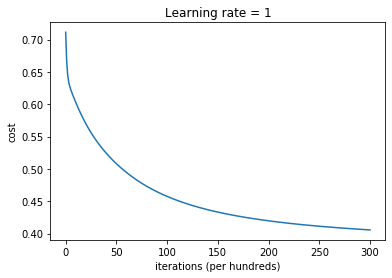

In [15]:
trained_parameters = model(X_train, Y_train, 3, 1, 300)

If everything works fine, the graph should be continuously decreasing. If this is not the case, there might be some error in some helper function or your model. Try fixing that. If everything worked fine move ahead.

### Predict (10)

Define a function that predicts the class given an input X. If the Neural Network ouputs a value greater than or equal to 0.5, the class is 1 and if it outputs a value less than 0.5, the class is 0.

<b>Input</b>: X, trained_prameters.<br>
<b>Output</b>: Predictions.<br>
<b>Hint</b>: You will use 1 helper function in this function.

In [16]:
def predict(X, trained_parameters):
    
    #Your code here and replace None with return value
    
    return 

### Accuracy (5)

Define a function that computes accuracy.

<b>Input</b>: Predictions, True Value.<br>
<b>Ouput</b>: Accuracy (a single real number).<br>
<b>Hint</b>: Remember that, $$\text{Accuracy} = \frac{\text{Number of values predicted correctly}}{\text{Total number of values}}$$

In [17]:
def accuracy(predictions, actual):
    
    #Your code here and replace None with return value
    
    return None

Run this piece of code to find the training and test set accuracy

In [20]:
print(f"Train set accruracy: {accuracy(predict(X_train, trained_parameters), Y_train)*100}"+"%")
print(f"Test set accuracy: {accuracy(predict(X_test, trained_parameters), Y_test)*100}"+"%")

Train set accruracy: 84.95575221238938%
Test set accuracy: 85.56701030927834%


Well, the accuracy of ANN is clearly far better than the accuracy of Logistic Regression. Let's see the Decision Boundary to see why.

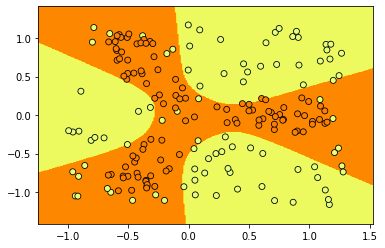

In [23]:
plot_decision_boundary(predict, X_test, Y_test, trained_parameters)

As we can see, the addition of a single hidden layer gives the ANN the capability of fitting a non-linear decision boundary. The activation function in the hidden layer adds this Non-Linear factor to the model. By adding more hidden layers we can fit even more complex functions.

<hr style="height:2px;border-width:2;color:gray">

## S3: Hyperparameter Tuning

In section 5.3 of the last notebook, we briefly saw what hyperparameters are. Hyperparameters are features of the model that you manually change to better fit the model to given data. The hyperparameters thay we can vary in this model are:
<ul>
    <li>Number of hidden units (n_H)</li>
    <li>Learning Rate (learning_rate)</li>
    <li>Number of iterations (num_iterations)</li>
</ul>
So go ahead and change the values of the hyperparameters to see how the accuracy and decision boundary change as you vary the hyperparameters. Also think about why these values change the way they do. Once you get a hang of it, try to get a high test accuracy.

<div class = "alert alert-block alert-info">
    <b>Note</b>:<br>
    <ul>
        <li>It is the <b>test</b> set accuracy that actually matters. So make sure your test set accuracy is close to the training accuracy and is not very less compared to the latter (this case is called <b>overfitting</b>). It is okay if test set accuracy is higher than the training accuracy.</li>
        <li>Your cost v/s iterations curve should be a smooth decreasing curve.</li>
    </ul>
</div>

Cost after iteration 0: 0.8014426270981452
Cost after iteration 100: 0.4306081375443213
Cost after iteration 200: 0.3211969128806569
Cost after iteration 300: 0.24088558069290947
Cost after iteration 400: 0.19012132844156363
Cost after iteration 500: 0.16051823772992807
Cost after iteration 600: 0.14121340162731463
Cost after iteration 700: 0.12699898482612382
Cost after iteration 800: 0.11580141476276597
Cost after iteration 900: 0.1067611212035789
Cost after iteration 1000: 0.09939516038078146
Cost after iteration 1100: 0.09335702580654584
Cost after iteration 1200: 0.08837063794344187


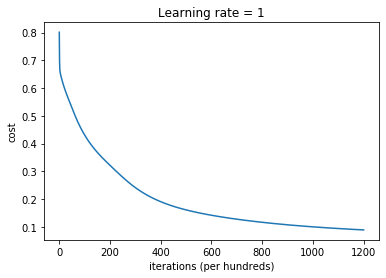

In [599]:
trained_parameters = model(X_train, Y_train, 7, 1, 1200)

In [600]:
print(f"Train set accruracy: {accuracy(predict(X_train, trained_parameters), Y_train)*100}"+"%")
print(f"Test set accuracy: {accuracy(predict(X_test, trained_parameters), Y_test)*100}"+"%")

Train set accruracy: 98.23008849557522%
Test set accuracy: 96.3917525773196%


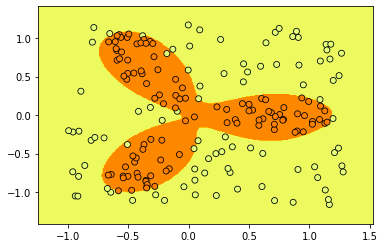

In [601]:
plot_decision_boundary(predict, X_test, Y_test, trained_parameters)

This final model of yours will be run on a hidden dataset and the accuracy will be noted.

<hr style="height:2px;border-width:2;color:gray">

## Conclusion

Great Job on completing this Assignment!!<br>
As you would have experienced, implementing a Neural Network from scratch is very painful. As you build deeper Neural Networks, you need to compute gradients for each of those steps and code it. In fact there are Neural Networks that go as deep as 150 layers! Imagine coding all that from scratch.<br>
That's where Machine Learning Frameworks come in to make our lives easier. All you need to do is set up the Neural Network architecture by defining the number of layers, number of hidden units etc. and you are ready to train it. The framework will take care of the hectic job of Backpropagation.<br>
In the next topic you'll be introduced to one such framework, Keras. So, Happy Learning !!

<hr style="height:5px;border-width:2;color:gray">